<a href="https://colab.research.google.com/github/enjolimarie/Projects-in-AI-ML/blob/main/Homework6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1:
 In this task you should work with the Facebook BART model
(https://huggingface.co/docs/transformers/en/model_doc/bart) to provide text summarization
of news articles. Text summarization in Natural Language Processing (NLP) is a technique that
breaks down long texts into sentences or paragraphs, while retaining the text's meaning and
extracting important information. Pick any one dataset of your choice.
You may have to do data cleaning, preprocessing etc. Next, perform the following tasks:
1. Provide a description of the dataset you selected. Split your data into train-test set with a (90-10) split.
2. Load the model from Hugging Face’s Transformers library and write its training script.
3. Fine tune the pre-trained model with your data and report results on your test set. You
must report the BLEU and ROUGE Scores. (See the code provided in class for more
details)
4. Analyze your results and discuss the impact of  hyperparameters. Are your results impacted by the choice of the LLM here? How?

Rouge and bleu scores resource:
https://www.geeksforgeeks.org/understanding-bleu-and-rouge-score-for-nlp-evaluation/

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

# Importing Hugging Face Datasets and Evaluate libraries
from datasets import Dataset
import evaluate
# Importing BART tokenizer, model, Trainer, TrainingArguments, and DataCollatorForSeq2Seq
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq

# Loading the BBC News dataset and skip any rows that are problematic
data = pd.read_csv("/content/bbc_news.csv", on_bad_lines='skip')
print("Data shape after loading:", data.shape)

# Drop rows with missing descriptions or titles to avoid errors
data.dropna(subset=['description', 'title'], inplace=True)

# Cleaning function for the datset
def clean_text(text):
    return text.strip()

data['description'] = data['description'].apply(clean_text)
data['title'] = data['title'].apply(clean_text)

# Part 1: Train-test split: 90% training, 10% testing
train_df, test_df = train_test_split(data, test_size=0.1, random_state=42)
print("Training shape:", train_df.shape)
print("Testing shape:", test_df.shape)

# Create Hugging Face Datasets from the Pandas DataFrames
train_dataset_hf = Dataset.from_pandas(train_df[['description', 'title']])
test_dataset_hf  = Dataset.from_pandas(test_df[['description', 'title']])

# Part 2: Loading the pre-trained BART tokenizer and model
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Set the device and move the model to that device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenizing data
# Max len for the input (description)
max_input_length = 512
# Max len for the target (title)
max_target_length = 50

def tokenize_function(example):
    # Tokenize the description (input text)
    model_inputs = tokenizer(example['description'], max_length=max_input_length, truncation=True)
    # Use the new `text_target` parameter to tokenize the title (target summary)
    labels = tokenizer(text_target=example['title'], max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Applying tokenize function to both train and test datasets
train_tokenized = train_dataset_hf.map(tokenize_function, batched=False)
test_tokenized = test_dataset_hf.map(tokenize_function, batched=False)

# Creating a DataCollator that pads the inputs and labels
# to the longest sequence in the batch
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Defining training arguments and create the Trainer
training_args = TrainingArguments(
    output_dir="./bart-finetuned-bbc",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    load_best_model_at_end=True,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
)

# Part 3: Fine-tuning the model
trainer.train()

# Evaluate model on test set using ROUGE and BLEU
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")

pred_summaries = []
ref_summaries = []

# Generate summaries for each test example using beam search with 4 beams
for example in test_dataset_hf:
    # Tokenize and move input tensor to the same device as the model
    input_ids = tokenizer.encode(example['description'], return_tensors='pt', truncation=True, max_length=max_input_length).to(device)
    output_ids = model.generate(input_ids, max_length=max_target_length, num_beams=4)
    pred_summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    pred_summaries.append(pred_summary)
    ref_summaries.append(example['title'])

# Compute BLEU and ROUGE scores using raw strings
bleu_result = bleu_metric.compute(predictions=pred_summaries, references=ref_summaries)
rouge_result = rouge_metric.compute(predictions=pred_summaries, references=ref_summaries)

# Printing scores obtained
print("BLEU Score:", bleu_result['bleu'])
print("ROUGE Scores:", rouge_result)


Data shape after loading: (42115, 5)
Training shape: (37903, 5)
Testing shape: (4212, 5)


Map:   0%|          | 0/37903 [00:00<?, ? examples/s]

Map:   0%|          | 0/4212 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.918700,2.668482
2,2.349700,2.563940


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


BLEU Score: 0.10383660626017545
ROUGE Scores: {'rouge1': np.float64(0.2767470536438191), 'rouge2': np.float64(0.119952565961775), 'rougeL': np.float64(0.2479864327193242), 'rougeLsum': np.float64(0.2482296965677997)}


# Dataset I have Used:

https://www.kaggle.com/datasets/gpreda/bbc-news


This is a set from Gabriel Preda that is said to collect RSS feeds and self-update while containing about almost 40,000 datapoints.

# Analyzing Results:

My experiment of the Facebook BART model on the BBC News dataset ran successfully which demonstrates the model’s ability to generate concise news summaries.

I began by cleaning the dataset and splitting it into a 90-10 train-test ratio as asked in the assignment, which I believe helped train the model better.

 During fine-tuning, I observed the training loss decrease from approximately 2.92 to 2.35 over two epochs which shows me there is effective learning happening while the validation loss remained relatively stable.

  The BLEU score of around 0.104 and ROUGE scores (ROUGE-1 ~0.277, ROUGE-2 ~0.120, ROUGE-L ~0.248) show a more moderate performance in capturing the essential content. The performance of this model was definitely influenced by the hyperparameters chosen. To be specific, the learning rate of 5e-5 gave a steady yet cautious convergence.
  
  Training for only two epochs might not have been sufficient to reach the model’s full potential. This is because the model took a while to run which means there could be room for further improvement of the model above if it had more time to run.
  
  Because of these constraints I also had to use a small batch size of 4 which introduced some gradient noise but still enabled the model to learn effectively.
  
  I also used beam search with 4 beams during inference, which helped in generating better coherent summaries.
  
  With the hyperparameters used, there is clearly room for improvement but there were just those constraints weighing on the GPU that I only have very minimal access of.
  
  It may be also important to mention that the BART-base model provided a solid starting point but its limited capacity compared to larger models might have constrained the overall performance on my BBC News dataset.
  
  I believe the experiment confirmed that every component which lies from data preprocessing to model tuning, played a big role in the final outcome.

# Task 2:
We discussed how we can formulate RL problems as an MDP. Describe any
real-world application that can be formulated as an MDP. Describe the state space, action
space, transition model, and rewards for that problem. You do not need to be precise in the
description of the transition model and reward (no formula is needed). Qualitative description
is enough.

# Answer: MDP in an Educational Setting
An example of an real world application that can be formulated as an MDP in the educational field would be an adaptive tutoring system.

In this hypothetical model, the state space would be the student's current knowledge and understanding. Each state may include factors like performance on quizzes, mastery of topics, and engagement levels.

The action space can include different teaching interventions available to the system. These actions can include introducing new material, offering review sessions, or even giving out quizzes to check student comprehension.

The transition model then explains how a student's state changes after an intervention. For example, presenting suitable content can help the student advance, while overly challenging material might lead to setbacks. The model could also account for variability in a student's day-to-day performance.

The reward structure is designed to encourage actions that result in improved learning outcomes. Rewards are given when the student shows progress or better performance, and penalties may be applied when performance declines. This setup allows the system to adjust its approach based on the student's responses. By framing the tutoring process as an MDP, the system can continuously learn and optimize its interventions for better educational results.

# Task 3:
 RL is used in various sectors - Healthcare, recommender systems and trading
are a few of those. Pick one of the three areas. Explain one of the problems in any of these
domains that can be more effectively solved by reinforcement learning. Find an open-source
project (if any) that has addressed this problem. Explain this project in detail.

# Answer


Here is the link to the open-source project that addresses the problem within my answer:

 https://github.com/augustebaum/RL-hospital

Within the field of healthcare, one of the many big challenge is the efficient allocation of patients to limited medical resources in hospitals. Patient flow management is important. It directly affects waiting times, quality of care, and overall hospital efficiency which is a current problem. The researchers have even reported how long people have waited within hospitals with important needs. Reinforcement learning can be used to tackle this problem by learning the optimal strategies to assign patients to available doctors based on their priority and based on the doctors’ skillsets or efficiencies. This model the gives potential to reduce patient waiting times and misallocations which can lead toward better patient outcomes and resource utilization in the hospital.

An open-source project that I have found addresses this problem. It is called the “RL-hospital” repository available on GitHub. This project simulates a hospital environment where patients arrive with different levels of need, and doctors, each with distinct types and treatment efficiencies, are available to treat them. The simulation is modeled as a discrete-time process where at every timestep a new patient is allocated to a queue corresponding to a doctor. The allocation decision, which is guided by an RL agent, aims to maximize a reward function that balances efficient patient treatment against the penalties incurred from misallocating patients or exceeding hospital capacity.

The repository is organized into several key components. The file hospital.py defines the Hospital class, which encapsulates the simulation of patient arrivals, treatment by doctors, and the progression of time within the hospital setting. This module also implements the reward system, which is crucial for the learning process as it provides immediate feedback based on the allocation decisions made by the agent. Learning.py contains the core reinforcement learning algorithms, including both SARSA and Q-Learning, as well as various state featurisations that convert the complex hospital state into a manageable representation for the RL agent. Other files such as feat_exp.py, fastdoc_exp.py, and rewards_exp.py run experiments to evaluate different featurisations and reward systems, and to analyze the behaviour of the learning agent under various conditions.

By using reinforcement learning, the project is able to explore and compare different strategies for patient allocation. The experiments illustrate that more sophisticated featurisations, particularly those using one-hot encoding, lead to more consistent and effective policies than simpler numerical representations. The work further demonstrates that the choice of the learning algorithm and the design of the reward system are crucial; for example, while SARSA converges faster, Q-Learning shows better long-term performance by reducing misallocations. Overall, the “RL-hospital” project provides a comprehensive simulation and experimental framework that showcases how reinforcement learning can be applied to optimize healthcare operations, making it a valuable resource for both academic research and practical applications in hospital management.

# Task 4:
 Implement the game of tic-tac-toe (write a class that implements an agent
playing Tic Tac Toe and learning its Q function) using the Q-learning technique (see the
resources/links provided in class for more details). Clearly describe your evaluation metric and
demonstrate a few runs. You might need to use some online resources to proceed with this. Do
not forget to cite those

In [3]:
import numpy as np
import random

# Reference for Q-learning implementation:
# https://medium.com/@goldengrisha/a-beginners-guide-to-q-learning-understanding-with-a-simple-gridworld-example-2b6736e7e2c9


#Reference to help build TicTacToe
# https://medium.com/@ardra4/tic-tac-toe-using-q-learning-a-reinforcement-learning-approach-d606cfdd64a3

class TicTacToe:
    def __init__(self):
        # 3x3 board represented as a list of 9 cells
        self.board = [' '] * 9
        self.current_winner = None

    def reset(self):
        self.board = [' '] * 9
        self.current_winner = None
        # Use tuple so it can be a key in Q-table
        return tuple(self.board)

    def available_actions(self):
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def make_move(self, square, letter):
        if self.board[square] == ' ':
            self.board[square] = letter
            if self.winner(square, letter):
                self.current_winner = letter
            return True
        return False

    def winner(self, square, letter):
        # Check row
        row_ind = square // 3
        row = self.board[row_ind*3:(row_ind*3 + 3)]
        if all([spot == letter for spot in row]):
            return True
        # Check column
        col_ind = square % 3
        col = [self.board[col_ind + i*3] for i in range(3)]
        if all([spot == letter for spot in col]):
            return True
        # Check diagonals (only possible if square is even)
        if square % 2 == 0:
            diag1 = [self.board[i] for i in [0, 4, 8]]
            if all([spot == letter for spot in diag1]):
                return True
            diag2 = [self.board[i] for i in [2, 4, 6]]
            if all([spot == letter for spot in diag2]):
                return True
        return False

    def is_draw(self):
        return ' ' not in self.board

    def step(self, action, letter):
        # Make a move and return the next state, reward, done, and extra info
        valid = self.make_move(action, letter)
        next_state = tuple(self.board)
        if self.current_winner == letter:
            # Win for the current player (agent or opponent)
            return next_state, 1, True, {}
        elif self.is_draw():
            # Draw if board is full and no winner
            return next_state, 0, True, {}
        else:
            # Non-terminal move has reward 0
            return next_state, 0, False, {}

    def render(self):
        for row in [self.board[i*3:(i+1)*3] for i in range(3)]:
            print("| " + " | ".join(row) + " |")
        print()

class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.2):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        # Q-table: key is state (as a tuple), value is a dict mapping action -> Q-value
        self.q_table = {}

    def get_q_values(self, state):
        if state not in self.q_table:
            # Initialize Q-values for all 9 positions; similar to initialization in the GridWorld example
            self.q_table[state] = {action: 0 for action in range(9)}
        return self.q_table[state]

    def choose_action(self, state, available_actions):
      # Referenced from the TicTacToe Site Above
        q_values = self.get_q_values(state)
        # Epsilon-greedy: explore vs. exploit
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(available_actions)
        else:
            # Choose the best action among available moves
            q_avail = {a: q_values[a] for a in available_actions}
            max_val = max(q_avail.values())
            best_actions = [a for a, v in q_avail.items() if v == max_val]
            return random.choice(best_actions)

    def update_q_value(self, state, action, reward, next_state, next_available_actions, done):
        current_q = self.get_q_values(state)[action]
        if done:
            max_future_q = 0
        else:
            next_q_values = self.get_q_values(next_state)
            if next_available_actions:
                max_future_q = max([next_q_values[a] for a in next_available_actions])
            else:
                max_future_q = 0
        # Q-learning update formula (as explained in the reference)
        new_q = current_q + self.lr * (reward + self.gamma * max_future_q - current_q)
        self.q_table[state][action] = new_q

# Training the Agent
env = TicTacToe()
agent = QLearningAgent(learning_rate=0.1, discount_factor=0.9, exploration_rate=0.2)

num_episodes = 5000
wins = 0
losses = 0
draws = 0

for episode in range(num_episodes):
  # This portion is referenced from TicTacToe Site but done a bit differently to set up env
  # and begin to play
    state = env.reset()
    done = False
    # True: agent ('X') turn; False: opponent ('O') turn
    turn = True
    last_agent_state, last_agent_action = None, None  # To store the agent's last state and action for potential penalty updates

    while not done:
        # Agent's turn
        if turn:
            # Get list of indices representing empty positions board
            available = env.available_actions()
            # Agent selects an action using its epsilon-greedy policy
            action = agent.choose_action(state, available)
            # Save current state and chosen action for later use if opponent wins
            last_agent_state, last_agent_action = state, action
            # Agent makes a move; env returns new state, reward, and done flag
            next_state, reward, done, _ = env.step(action, 'X')
            # If game is not over, compute available moves in next state. else: empty list
            next_available = env.available_actions() if not done else []
            # Update Q-value using the agent's update method based on the observed reward and next state
            agent.update_q_value(state, action, reward, next_state, next_available, done)
            state = next_state  # Move to the next state after the agent's action
            if done:
                # Outcome evaluation for agent's move
                if reward == 1:
                  # Increment win counter if agent wins
                    wins += 1
                elif reward == 0:
                  # Increment draw counter if the game ends in a draw
                    draws += 1

        # Opponent's turn (random move)
        else:
          # Get the available moves for the opponent
            available = env.available_actions()
            if not available:
              # If no moves are available, the game is over (draw)
                done = True
              # Increment Draw
                draws += 1
                break
            # Opponent randomly selects move from available actions
            opponent_action = random.choice(available)
            # Execute opponent's move
            next_state, reward, done, _ = env.step(opponent_action, 'O')
            if done:
                # Outcome evaluation for opponent's move
                # If the opponent wins, update the agent's Q-value for its last move to penalize the agent
                if reward == 1:
                    agent.update_q_value(last_agent_state, last_agent_action, -1, next_state, [], done)
                    # Incrementing loss counter if opponent wins
                    losses += 1
                elif reward == 0:
                    draws += 1
            # Update state after opponent's move
            state = next_state

        # Toggling turn to alternate between the agent and the opponent
        turn = not turn


# Print evaluation metrics after training
print("Training completed over {} episodes.".format(num_episodes))
print("Evaluation Metrics:")
print("Wins: {}  Losses: {}  Draws: {}".format(wins, losses, draws))

# Demonstration Run:
# For demonstration, disable exploration to see the learned strategy
agent.epsilon = 0

def play_game(agent, env):
    # Reset game environment to start a new game and get the initial state.
    state = env.reset()
    done = False
    # Set turn to True to indicate it's the agent ('X') turn first.
    turn = True
    print("Starting new game:")
    # Display the initial empty board.
    env.render()

    # Continue game loop until game ends with a win or draw
    while not done:
        if turn:
            # Agent's turn ('X'):
            # Get list of available moves
            available = env.available_actions()
            # Agent chooses an action based on its policy
            action = agent.choose_action(state, available)
            # Take the action, update the state, get reward and check if game is finished
            state, reward, done, _ = env.step(action, 'X')
            print("Agent ('X') moves to position:", action)
            # Render board after agent's move
            env.render()
            if done:
                # If game is done, determine outcome based on reward.
                if reward == 1:
                    print("Agent wins!")
                elif reward == 0:
                    print("Draw!")
        else:
            # Opponent's turn ('O'):
            # Get list of available moves.
            available = env.available_actions()
            if not available:
                # No moves left, break out of the loop (shouldn't normally occur due to draw check).
                break
            # Opponent selects a random available move.
            opponent_action = random.choice(available)
            # Execute the move for the opponent.
            state, reward, done, _ = env.step(opponent_action, 'O')
            print("Opponent ('O') moves to position:", opponent_action)
            env.render()  # Render the board after the opponent's move.
            if done:
                # If the game is finished, determine the outcome based on the reward.
                if reward == 1:
                    print("Opponent wins!")
                elif reward == 0:
                    print("Draw!")
        # Alternate turns between the agent and the opponent.
        turn = not turn


# Running a few demonstration games
for _ in range(3):
    play_game(agent, env)
    #Separating the games
    print("--------------------------------------------------")


Training completed over 5000 episodes.
Evaluation Metrics:
Wins: 3495  Losses: 993  Draws: 512
Starting new game:
|   |   |   |
|   |   |   |
|   |   |   |

Agent ('X') moves to position: 2
|   |   | X |
|   |   |   |
|   |   |   |

Opponent ('O') moves to position: 0
| O |   | X |
|   |   |   |
|   |   |   |

Agent ('X') moves to position: 8
| O |   | X |
|   |   |   |
|   |   | X |

Opponent ('O') moves to position: 4
| O |   | X |
|   | O |   |
|   |   | X |

Agent ('X') moves to position: 7
| O |   | X |
|   | O |   |
|   | X | X |

Opponent ('O') moves to position: 6
| O |   | X |
|   | O |   |
| O | X | X |

Agent ('X') moves to position: 5
| O |   | X |
|   | O | X |
| O | X | X |

Agent wins!
--------------------------------------------------
Starting new game:
|   |   |   |
|   |   |   |
|   |   |   |

Agent ('X') moves to position: 5
|   |   |   |
|   |   | X |
|   |   |   |

Opponent ('O') moves to position: 3
|   |   |   |
| O |   | X |
|   |   |   |

Agent ('X') moves to p

# Describing Evaluation Metric at top of Output Code

The evaluation metric is based on tracking the agent's performance over a fixed number of training episodes. We record the number of wins (when the agent wins the game and receives a reward of +1), losses (when the opponent wins, causing a negative impact on the agent's Q-value), and draws (when the board fills without a winner, resulting in a neutral reward of 0). This metric quantifies the agent’s learning progress by showing how frequently it wins, loses, or ties over time.

# Task 5:
 For this task use the MovieLens 100k dataset
(https://grouplens.org/datasets/movielens/100k/)
Perform the necessary data cleaning, EDA and conversion to User-item matrix.
Implement any 2 collaborative filtering recommendation systems (RecSys) algorithms covered
in class (Matrix Factorization, Alternating Least Squares, NCF etc.) and compare their
performance for any 2-evaluation metrics used for RecSys. You may read literature to find out
which evaluation metrics are used for RecSys. Cite all your research.

In [2]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 78.8 MB/s eta 0:00:00


Number of unique users: 943
Number of unique items: 1682


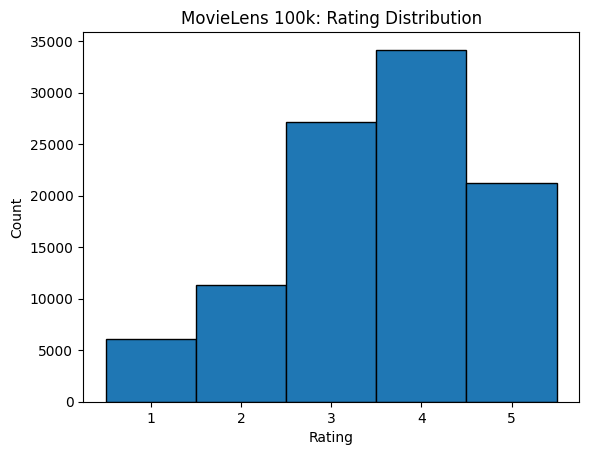

Dense rating matrix R with shape: (943, 1682)
Iteration Num: 10 ; RMSE Score = 0.9177
Iteration Num: 20 ; RMSE Score = 0.8873
Iteration Num: 30 ; RMSE Score = 0.8130
Iteration Num: 40 ; RMSE Score = 0.7354
Iteration Num: 50 ; RMSE Score = 0.6774


  0%|          | 0/50 [00:00<?, ?it/s]


ALS Evaluation:
RMSE: 3.1788
MAE:  2.9894
Comparison of Models
Matrix Factorization Results: RMSE: 0.9384, MAE: 0.7353
ALS Results: RMSE: 3.1788, MAE: 2.9894


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix
import implicit

# Data loading and facrotiiznf usr and items
# Loading the MovieLens 100k dataset from my google drive
data = pd.read_csv(
    "/content/drive/MyDrive/ml-100k/u.data",
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"]
)

# Factorizing user_id and item_id into contiguous 0-based indices
data["user_idx"], user_unique = data["user_id"].factorize()
data["item_idx"], item_unique = data["item_id"].factorize()

# For reference, the number of unique users and items are:
# Checking that it should be 943
num_users = data["user_idx"].nunique()
# Checking that it should be 1682
num_items = data["item_idx"].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")

# EDA: Rating distribution
plt.hist(data["rating"], bins=np.arange(0.5, 6, 1), edgecolor="black")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("MovieLens 100k: Rating Distribution")
plt.show()

# Constructing the user-item matrix manually
# Creating a dense matrix R of shape (num_users x num_items), initialized to 0
R = np.zeros((num_users, num_items), dtype=np.float32)

# Fill R with the ratings
for row in data.itertuples(index=False):
    # row has: user_id, item_id, rating, timestamp, user_idx, item_idx
    R[row.user_idx, row.item_idx] = row.rating

#Had to print shape for debugging purposes
print("Dense rating matrix R with shape:", R.shape)

# Creating train/test splits
# Gathering indices of all non-zero ratings in R
non_zero_indices = np.array([
    (u, i)
    for u in range(num_users)
    for i in range(num_items)
    if R[u, i] > 0
])

# Split these into training and test sets
train_idx, test_idx = train_test_split(
    non_zero_indices, test_size=0.2, random_state=42
)

# Create training matrix R_train by zeroing out test entries
R_train = R.copy()
for (u, i) in test_idx:
    R_train[u, i] = 0.0

# Store test ratings in y_true for evaluation
y_true = [R[u, i] for (u, i) in test_idx]



# Matrix factorization using stochastic gradient descent
# This entire class portion is
# referenced from: https://ayeung.dev/2017/04/23/python-matrix-factorization.html
class MF:
    def __init__(self, rating_matrix, num_latent, learning_rate, reg_param, n_iters):
        # Matrix factorization to predict missing entries in rating_matrix.

        # A user-item rating matrix of shape (num_users, num_items)
        self.R = rating_matrix
        self.num_users, self.num_items = rating_matrix.shape
        # Num of latent dimensions
        self.K = num_latent
        # Learning rate for updates
        self.lr = learning_rate
        # Regularization parameter
        self.reg_param = reg_param
        # Num of SGD iterations
        self.n_iters = n_iters

    def initialize_parameters(self):
        # Initialize latent factor matrices for users and items
        self.user_factors = np.random.normal(scale=1.0/self.K, size=(self.num_users, self.K))
        self.item_factors = np.random.normal(scale=1.0/self.K, size=(self.num_items, self.K))

        # Initialize biases for users and items
        self.user_bias = np.zeros(self.num_users)
        self.item_bias = np.zeros(self.num_items)
        # Global bias: mean of the observed ratings
        self.global_bias = np.mean(self.R[self.R > 0])

        # Prepare list of non-zero samples for SGD
        self.train_samples = [
            (u, i, self.R[u, i])
            for u in range(self.num_users)
            for i in range(self.num_items)
            if self.R[u, i] > 0
        ]

    def train(self):
        # Setup initial parameters and latent factors
        self.initialize_parameters()

        # Stochastic Gradient Descent loop
        for iteration in range(self.n_iters):
            np.random.shuffle(self.train_samples)
            self.sgd_update()
            current_rmse = self.compute_rmse()
            if (iteration + 1) % 10 == 0:
                print(f"Iteration Num: {iteration+1} ; RMSE Score = {current_rmse:.4f}")
        return self

    def compute_rmse(self):
        # Computing RMSE on non-zero entries
        observed_users, observed_items = self.R.nonzero()
        full_pred = self.full_matrix()
        squared_errors = [
            (self.R[u, i] - full_pred[u, i]) ** 2
            for u, i in zip(observed_users, observed_items)
        ]
        return np.sqrt(np.mean(squared_errors))

    def sgd_update(self):
        # Performing one epoch of SGD on all non-zero training samples
        for user, item, true_rating in self.train_samples:
            pred_rating = self.predict_rating(user, item)
            error = true_rating - pred_rating

            # Updating biases
            self.user_bias[user] += self.lr * (error - self.reg_param * self.user_bias[user])
            self.item_bias[item] += self.lr * (error - self.reg_param * self.item_bias[item])

            # Updating latent factors
            self.user_factors[user] += self.lr * (error * self.item_factors[item] - self.reg_param * self.user_factors[user])
            self.item_factors[item] += self.lr * (error * self.user_factors[user] - self.reg_param * self.item_factors[item])

    def predict_rating(self, user, item):
        #Predict rating = global bias + user bias + item bias + latent dot product
        return (self.global_bias
                + self.user_bias[user]
                + self.item_bias[item]
                + np.dot(self.user_factors[user], self.item_factors[item].T))

    def full_matrix(self):
        # Computing the full rating matrix from learned factors and biases
        return (self.global_bias
                + self.user_bias[:, np.newaxis]
                + self.item_bias[np.newaxis, :]
                + self.user_factors.dot(self.item_factors.T))


# Training the MF model
mf_model = MF(R_train, num_latent=20, learning_rate=0.005, reg_param=0.02, n_iters=50)
mf_model.train()

# Predict using the trained MF model
R_pred_mf = mf_model.full_matrix()

# Evaluating MF on the test set
y_pred_mf = [R_pred_mf[u, i] for (u, i) in test_idx]
mf_rmse = np.sqrt(mean_squared_error(y_true, y_pred_mf))
mf_mae = mean_absolute_error(y_true, y_pred_mf)


# Alternating least squares with implicit
# Referencing From: https://medium.com/@anurag.tech/movie-recommendation-system-using-alternating-least-squares-14c7bed98f08

# Create sparse matrix from the training data
# my current shape shape = (num_users, num_items) = (943, 1682)
user_item_sparse = csr_matrix(R_train)

#As referenced from the site but only with one param instead
als_params = {
    'factors': 20,
    'regularization': 0.1,
    'iterations': 50
}

# Made from the referennce given above
als_model = implicit.als.AlternatingLeastSquares(
    factors=als_params['factors'],
    regularization=als_params['regularization'],
    iterations=als_params['iterations'],
    random_state=42,
    calculate_training_loss=True,
    use_gpu=False
)

# Fit the ALS model in a (items x users) matrix
# Transposing the data before fitting
als_model.fit(user_item_sparse.T.tocsr())

# Define prediction function with correct indexing
def als_predict(u, i):
    #Predict rating using the implicit ALS model.

    #Since the matrix is transposed for fitting, the indicies have to be carefully done:
    # - als_model.user_factors contains item latent factors (size: num_items x factors)
    # - als_model.item_factors contains user latent factors (size: num_users x factors)
    return als_model.item_factors[u].dot(als_model.user_factors[i].T)

# Evaluate ALS on test set
y_pred_als = [als_predict(u, i) for (u, i) in test_idx]
als_rmse = np.sqrt(mean_squared_error(y_true, y_pred_als))
als_mae = mean_absolute_error(y_true, y_pred_als)

print("\nALS Evaluation:")
print(f"RMSE: {als_rmse:.4f}")
print(f"MAE:  {als_mae:.4f}")

# Comparing results
print("Comparison of Models")
print(f"Matrix Factorization Results: RMSE: {mf_rmse:.4f}, MAE: {mf_mae:.4f}")
print(f"ALS Results: RMSE: {als_rmse:.4f}, MAE: {als_mae:.4f}")
